In [1]:
import numpy as np
import pandas as pd



**隐含波动率**






**_Black-Scholes-Merton期权定价公式_**
$$
C(S_{i},K,t,T,r,\sigma)=S_{i}*N(d_{1})-e^{-r(T-t)}*K*N(d_{2})
$$


$$
N(d)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{d} e^{-\frac{1}{2}x^{2}} dx
$$

$$
d_{1}=\frac{log\frac{S_{t}}{K}+\{r+\frac{\sigma^{2}}{2} \}(T-t)}{\sigma\sqrt{T-t}}
$$

$$
d_{2}=\frac{log\frac{S_{t}}{K}+\{r-\frac{\sigma^{2}}{2} \}(T-t)}{\sigma\sqrt{T-t}}
$$


参数意义：

$S_{t}$  在时点t的标的物价格水平；

$\sigma$ 标的物固定波动率（也就是收益的标准差）

K 期权行权价格

T 期权到期日

r 固定无风险短期利率

N(d) 表示为标准正态分布


_给定期权报价的隐含波动率_
$$
C(S_{i},K,t,T,r,\sigma^{imp})=C^{*}
$$

通过牛顿迭代法等可以计算出$\sigma^{imp}$的值，公式如下所示
$$
\sigma^{imp}_{n+1}=\sigma^{imp}_{n}-\frac{C(\sigma^{imp}_{n})-C^{*}}{\partial C(\sigma_{n}^{imp})/ \partial \sigma^{imp}_{n}}
$$


BSM期权定价模型中得vega
$$
\frac{\partial C}{\partial \sigma}=S_{t}N(d_{1})\sqrt{T-t}
$$


In [2]:
def bsm_call_value(S0,K,T,r,sigma):
    from math import sqrt, log,exp
    from scipy import stats
    S0=float(S0)
    d1=(log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2=(log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*sqrt(T))
    
    value=S0*stats.norm.cdf(d1,0,1)-exp(-r*T)*K*stats.norm.cdf(d2,0,1)
    return value

def bsm_vega(S0,K,T,r,sigma):
    from math import log,sqrt
    from scipy import stats
    
    S0=float(S0)
    d1=d1=(log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    vega=S0*stats.norm.cdf(d1,0,1)*sqrt(T)
    return vega


#隐含波动率计算

def bsm_call_imp_vol(S0,K,T,r,C0,sigma_est,it=100):
    #sigma_est :  估计的sigma值
    #it 迭代次数
    
    for i in range(it):
        sigma_est-=(bsm_call_value(S0,K,T,r,sigma_est)-C0)/bsm_vega(S0,K,T,r,sigma_est)
        
    return sigma_est
    
    

In [3]:
h5=pd.HDFStore('C:/Users/15295/Desktop/量化金融/financepy-master/part1/ch03/source/vstoxx_data_31032014.h5','r')
futures_data=h5['futures_data']
options_data=h5['options_data']
h5.close()

In [4]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [5]:
options_data

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,2014-03-31,2014,4,C,1.0,16.85,2014-04-18,0.049
46171,2014-03-31,2014,4,C,2.0,15.85,2014-04-18,0.049
46172,2014-03-31,2014,4,C,3.0,14.85,2014-04-18,0.049
46173,2014-03-31,2014,4,C,4.0,13.85,2014-04-18,0.049
46174,2014-03-31,2014,4,C,5.0,12.85,2014-04-18,0.049
...,...,...,...,...,...,...,...,...
46560,2014-03-31,2014,11,C,85.0,0.05,2014-11-21,0.644
46561,2014-03-31,2014,11,C,90.0,0.05,2014-11-21,0.644
46562,2014-03-31,2014,11,C,95.0,0.05,2014-11-21,0.644
46563,2014-03-31,2014,11,C,100.0,0.05,2014-11-21,0.644


In [6]:
options_data.columns

Index(['DATE', 'EXP_YEAR', 'EXP_MONTH', 'TYPE', 'STRIKE', 'PRICE', 'MATURITY',
       'TTM'],
      dtype='object')

In [7]:
#定义一个新列用于储存结果

options_data['imp_vol']=0

In [8]:
V0=17.6639
r=0.01
tol=0.5
for option in options_data.index:
    
    forward=futures_data[futures_data['MATURITY']==options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    
    if (forward*(1-tol)<options_data.loc[option]['STRIKE']<forward*(1+tol)):
        imp_vol=bsm_call_imp_vol(
        V0,
        options_data.loc[option]['STRIKE'],#期权行权价格
        options_data.loc[option]['TTM'],#期权到期价格
        r,
        options_data.loc[option]['PRICE'],
        sigma_est=2.,
        it=100)
        options_data.loc[option,'imp_vol']=imp_vol

In [9]:
options_data['imp_vol'].value_counts()

0.000000    237
0.791433      1
1.184727      1
1.069384      1
0.981718      1
           ... 
0.870737      1
0.865472      1
0.872362      1
0.872663      1
0.805459      1
Name: imp_vol, Length: 159, dtype: int64

In [10]:
#进行可视化
plot_data=options_data[options_data['imp_vol']>0]

maturities=sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

C:\Users\15295\AppData\Local\Temp\ipykernel_21716\372713768.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=plot_data[options_data.MATURITY==maturity]


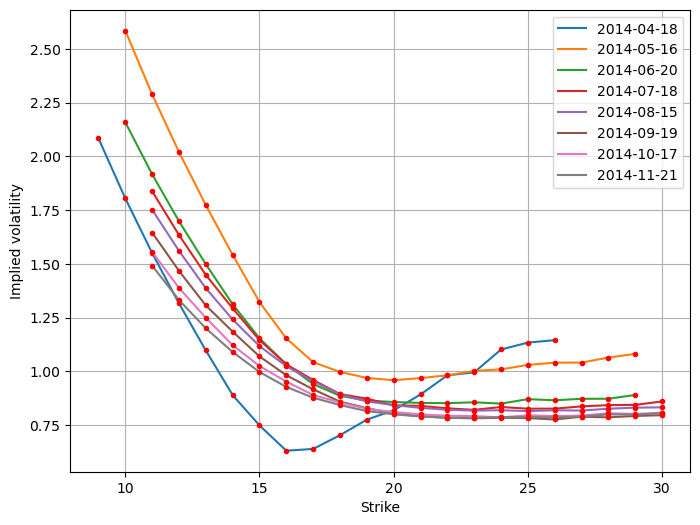

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

for maturity in maturities:
    data=plot_data[options_data.MATURITY==maturity]
    plt.plot(data['STRIKE'],data['imp_vol'],
            label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'],data['imp_vol'],'r.')
plt.grid(True)
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.legend()
plt.show()

In [12]:
keep=['PRICE','imp_vol']
group_data=plot_data.groupby(['MATURITY','STRIKE'])[keep]
group_data=group_data.sum()
group_data

PRICE   imp_vol
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.083386
           10.0     7.85  1.804194
           11.0     6.85  1.550283
           12.0     5.85  1.316103
           13.0     4.85  1.097184
...                  ...       ...
2014-11-21 26.0     2.20  0.785411
           27.0     2.05  0.789241
           28.0     1.95  0.800016
           29.0     1.80  0.798958
           30.0     1.70  0.805459

[158 rows x 2 columns]

**蒙特卡洛模拟**

_Black-Scholes-Merton随机微分方程_
$$
dS_{t}=rS_{t}dt+\sigma S_{t}dZ_{t}
$$

其中Z是一个布朗运动，其中SDE的离散化由下面给出

$$
S_{t}=S_{t-\delta t}exp((r-\frac{1}{2}\sigma^{2})\delta t +\sigma \sqrt{\delta t}z_{t})
$$

变量Z是标准正态分布随机变量



In [13]:
S0=100.
K=105.
T=1.0
r=0.05
sigma=0.2
bsm_call_value(S0,K,T,r,sigma)

8.021352235143176

**蒙特卡洛估值步骤：**

1.将时间间隔[0,T]分为等距的、长度为$\delta t$的子时段

2.开始循环i=1，2，3,...,I

1）对于每个时间步t，取伪随机数Z

2）逐个时间步应用伪随机数，确定指数水平$S_{T}(i)$的T值，进行离散化SDE

3）确定时间T时点欧式看涨期权的内在价值ht:$h_{t}(ST(i))=max(ST(i)-k,0)$

4)循环到i=T


**欧式看涨期权价值的蒙特卡洛估算函数**
$$
C_{0}=e^{rT}\frac{1}{I}\sum_{i}h_{T}(S_{T}(i))
$$

In [14]:
from time import time 
from math import exp,sqrt, log
from random import gauss,seed

seed(2000)
t0=time()
S0=100 #最初的价格
K=105  #行权价格
T=1.0  
r=0.05
sigma=0.2  #波动率
M=50 #时间步数
dt=T/M  #时间间隔


I=250
S=[]
for i in range(I):
    path=[]
    for t in range(M+1):
        if t==0:
            path.append(S0)
        else:
            z=gauss(0.0,1.0)
            St=path[t-1]*exp((r-0.5*sigma**2)*dt+sigma*sqrt(dt)*z)
            path.append(St)
        S.append(path)
        
    C0=exp(-r*T)*sum([max(path[-1]-K,0) for path in S])/I
    
    tpy=time()-t0
    
    

_利用对数欧拉方法实现全向量化_

公式转变为:

$$
logS_{t}=logS_{t-\delta t}+(r-\frac{1}{2}\sigma^{2})\delta t+\sigma\sqrt{\delta t}z_{t}
$$



In [15]:
from numpy import *
random.seed(2000)
t0=time()

S0=100;K=105;T=1.0;r-0.05;sigma=0.2;M=50;dt=T/M;I=2500
S=S0*exp(cumsum((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*random.standard_normal((M+1,I)),axis=0))
S[0]=S0

C0=math.exp(-r*T)*sum(maximum(S[-1]-K,0))/I

C0

8.795389709888472

Text(0, 0.5, 'Index Level')

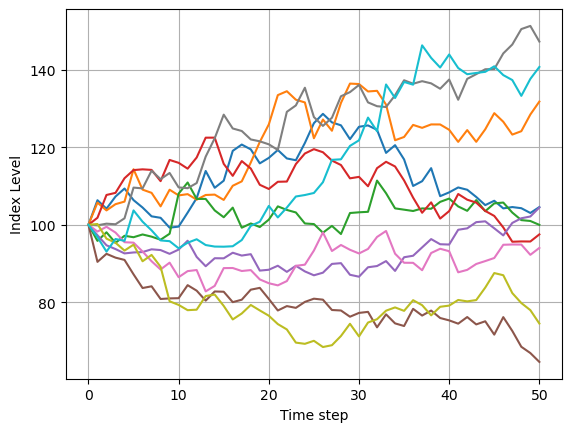

In [16]:
plt.plot(S[:,:10])
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('Index Level')

Text(0, 0.5, 'frequency')

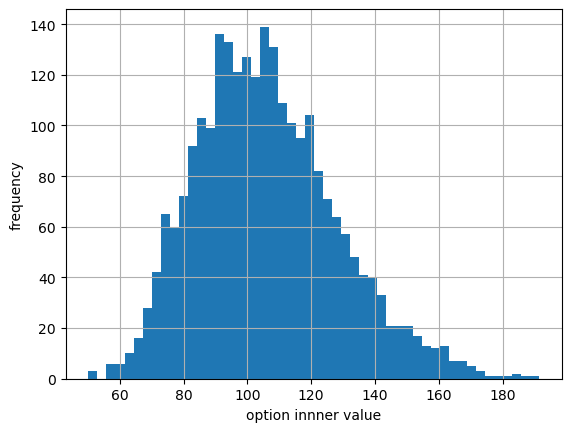

In [17]:
plt.hist(S[-1],bins=50)
plt.grid(True)
plt.xlabel('option innner value')
plt.ylabel('frequency')


# 技术分析

In [27]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web

In [28]:
from pandas_datareader import data as pdr

import yfinance as yf 
yf.pdr_override() # <== that's all it takes :-) 

# download dataframe 
df= pdr.get_data_yahoo("^GSPC", start="2000-01-01", end="2014-04-14") 

[*********************100%***********************]  1 of 1 completed


In [29]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
2014-04-07,1863.920044,1864.040039,1841.479980,1845.040039,1845.040039,3801540000
2014-04-08,1845.479980,1854.949951,1837.489990,1851.959961,1851.959961,3721450000
2014-04-09,1852.640015,1872.430054,1852.380005,1872.180054,1872.180054,3308650000


In [30]:
import plotly.graph_objs as go
import plotly as py

pyplt=py.offline.plot
trace=go.Candlestick(x=df[:1000].index,
                     open=df[:1000].Open,
                   close=df[:1000].Close,
                   high=df[:1000].High,
                   low=df[:1000].Low,
                   increasing=dict(line=dict(color='red')),
                  decreasing=dict(line=dict(color='green')))

layout=go.Layout(title='K线图',
                width=800,
                 xaxis=dict(title='时间',
                           titlefont=dict(color='black')),
                 yaxis=dict(title='价格',
                           titlefont=dict(color='#1f77b4'))
                )

data=[trace]
fig=go.Figure(data=data,layout=layout)
fig

<AxesSubplot:xlabel='Date'>

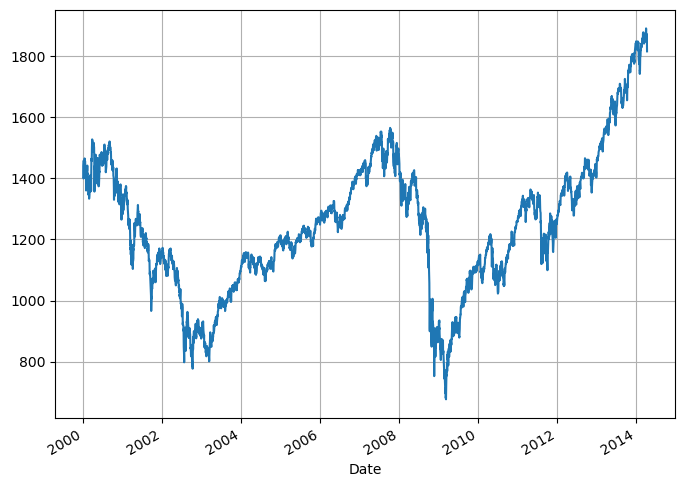

In [31]:
df['Close'].plot(grid=True,figsize=(8,6))

In [32]:
#42个交易日的趋势图和252个交易日的趋势图

df['42d']=np.round(df.Close.rolling(42).mean(),2)
df['252d']=np.round(df.Close.rolling(252).mean(),2)

<AxesSubplot:xlabel='Date'>

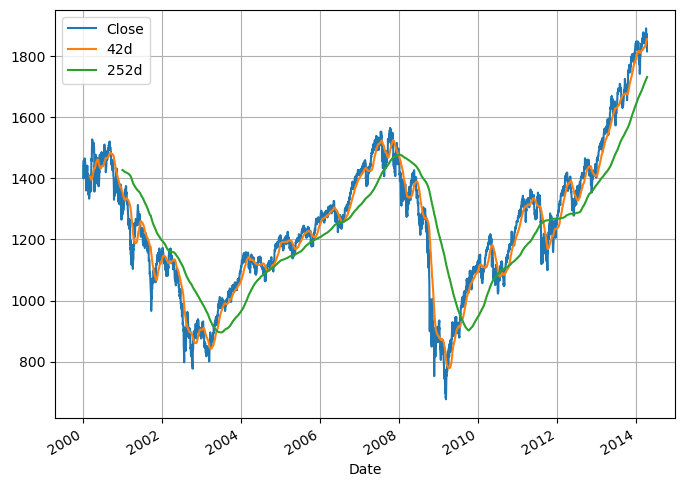

In [33]:
df[['Close','42d','252d']].plot(grid=True,figsize=(8,6))

**买入信号（多头）**

42天趋势第一次高于252天趋势SD点

**等待（持币）**

42天趋势在252天趋势+/-SD点范围内

**卖出信号（空头）**

42天趋势第一次低于252天趋势SD点



In [34]:
df['42-252']=df['42d']-df['252d']

SD=50
df['Regime']=np.where(df['42-252']>SD,1,0)
df['Regime']=np.where(df['42-252']<-SD,-1,df['Regime'])
df['Regime'].value_counts()

 1    1488
 0    1232
-1     871
Name: Regime, dtype: int64

(-1.1, 1.1)

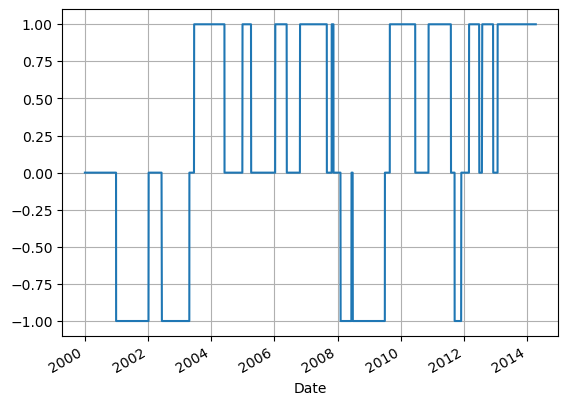

In [35]:
df['Regime'].plot(lw=1.5,grid=True)
plt.ylim([-1.1,1.1])

根据各自的投资体制，投资者可能做空、做多市场

In [37]:
df['Market']=np.log(df['Close']/df['Close'].shift(1))#对数收益率

In [40]:
df['Strategy']=df['Regime'].shift(1)*df['Market']

<AxesSubplot:xlabel='Date'>

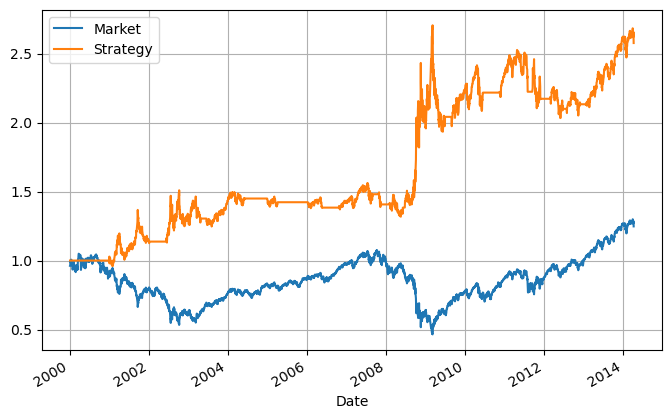

In [41]:
df[['Market','Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(8,5))